<a href="https://colab.research.google.com/github/RenSnowball/XGboost-for-Diabetes-Data/blob/main/5250_xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
!pip install scikit-survival
!pip install shap
!pip install pdpbox
!pip install sklearn.ensemble.partial_dependence
!pip install scikit-survival
# from sksurv.datasets import load_veterans_lung_cancer
# from sksurv.ensemble import RandomSurvivalForest
# from sksurv.preprocessing import OneHotEncoder
# from sksurv.metrics import concordance_index_censored
# import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import shap
import matplotlib.pyplot as plt
from pdpbox import pdp, info_plots



ERROR: Could not find a version that satisfies the requirement sklearn.ensemble.partial_dependence (from versions: none)
ERROR: No matching distribution found for sklearn.ensemble.partial_dependence


In [ ]:
df = pd.read_csv('SSC-FIRSTDAY.csv')
# df = df.dropna(axis=1)

# Drop columns that contain 'LODS' in their name
df = df.loc[:, ~df.columns.str.contains('LODS')]
df = df.loc[:, ~df.columns.str.contains('OASIS')]
df = df.loc[:, ~df.columns.str.contains('APS')]
# 将分类变量转换为数值
label_encoder = LabelEncoder()
df['admission_type_encoded'] = label_encoder.fit_transform(df['admission_type'])
print(df)
# Display the data types of each column
print(df.dtypes)

     stay_id  subject_id     hadm_id  ICU_length_of_stay hospital_expire_flag  \
0   35788723  [19739493]  [23894396]            4.686898                  [1]   
1   35899133  [14560675]  [22415374]            9.746447                  [1]   
2   39278751  [19439870]  [29893640]            3.310428                  [0]   
3   39123899  [11522912]  [22953852]           31.653993                  [0]   
4   36931239  [17210302]  [29897905]            3.507836                  [0]   
..       ...         ...         ...                 ...                  ...   
92  36188145  [14441506]  [28327879]            1.660984                  [1]   
93  38309084  [18651030]  [20582772]            2.298345                  [0]   
94  39733376  [15347247]  [29821193]            1.024340                  [0]   
95  34281325  [10951689]  [26423804]            5.385880                  [1]   
96  34406519  [10521666]  [28942795]           29.218449                  [0]   

    age admission_type  num

In [ ]:
# 加载数据
X = df.drop(['stay_id', 'subject_id', 'hadm_id', 'ICU_length_of_stay', 'hospital_expire_flag','admission_type'], axis=1)
y = df['ICU_length_of_stay'].astype(float)  # 确保目标变量是数值类型

# 对分类变量进行编码
X_encoded = pd.get_dummies(X, drop_first=True)

# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# 创建 XGBoost 回归模型
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror')

For the icu length prediction by XGBoost regression model

In [ ]:


# 设置参数网格
params = {
    'max_depth': [3, 5, 8],
    'learning_rate': [ 0.01,  0.1, 0.2],
    'n_estimators': [100,  500, 1000],
    # 'subsample': [0.6, 0.8, 1.0],
    # 'min_child_weight': [1, 3, 5],
    # 'gamma': [0, 0.05, 0.1, 0.2],
    # 'colsample_bytree': [0.5,  0.8,  1.0]
}

# 创建 GridSearchCV 对象
grid = GridSearchCV(estimator=xg_reg, param_grid=params, scoring='neg_mean_squared_error', cv=3, verbose=1)

# 训练模型
grid.fit(X_train, y_train)

# 打印最佳参数和最佳模型的分数
print("Best parameters found: ", grid.best_params_)
print("Best score: ", grid.best_score_)

# 使用最佳模型对测试集进行预测
predictions = grid.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("MSE: ", mse)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters found:  {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 100}
Best score:  -105.40714658486122
MSE:  29.967614095968457


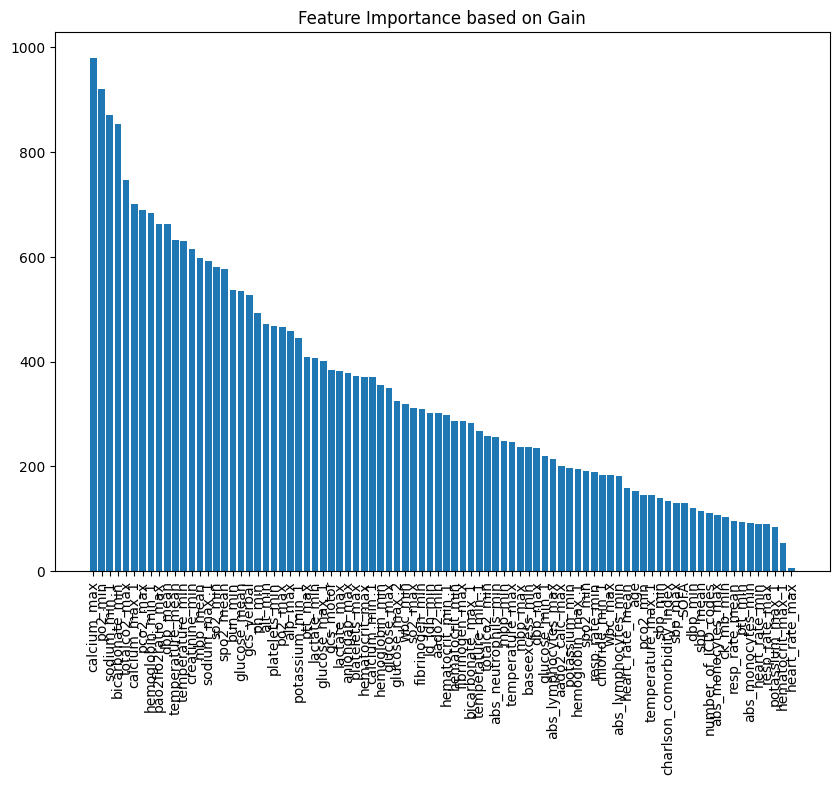

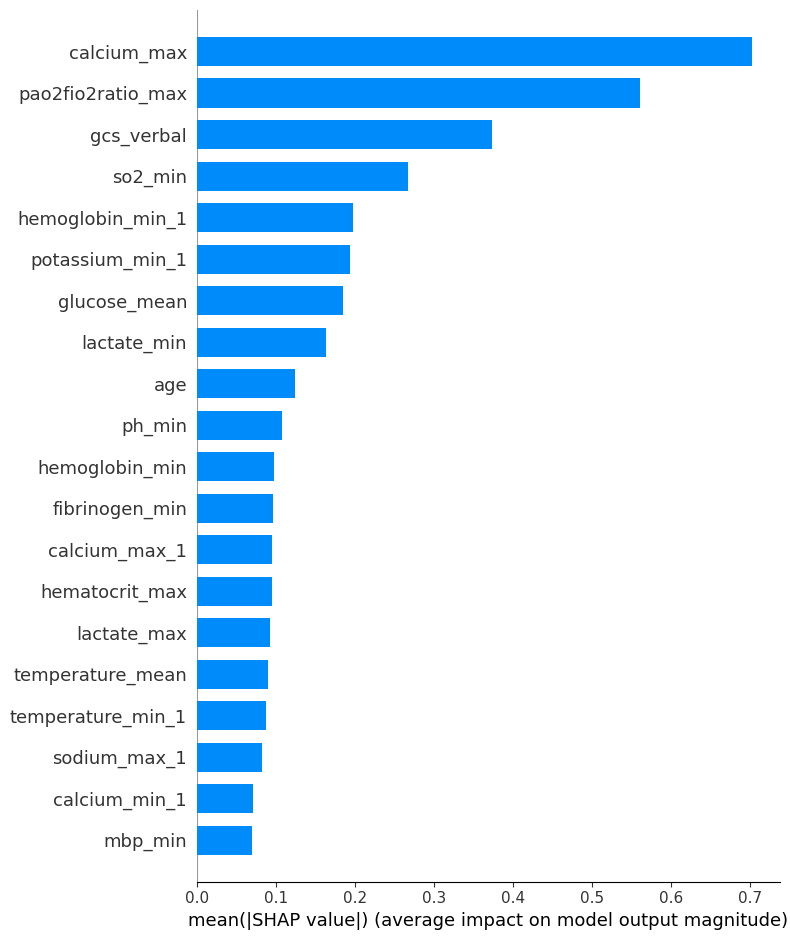

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# 初始化并训练 XGBoost 模型
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', max_depth=3, learning_rate=0.01, n_estimators=100, subsample=0.8)
xg_reg.fit(X_train, y_train)  # 确保模型已被训练

# 现在你可以安全地获取 Gain 型特征重要性
feature_importances_gain = xg_reg.get_booster().get_score(importance_type='gain')
sorted_idx_gain = sorted(feature_importances_gain, key=feature_importances_gain.get, reverse=True)

# 绘制特征重要性
plt.figure(figsize=(10, 7))
plt.title("Feature Importance based on Gain")
plt.bar(range(len(sorted_idx_gain)), [feature_importances_gain[i] for i in sorted_idx_gain], align='center')
plt.xticks(range(len(sorted_idx_gain)), sorted_idx_gain, rotation=90)
plt.show()

# 使用 SHAP 解释模型
explainer = shap.TreeExplainer(xg_reg)
shap_values = explainer.shap_values(X_train)

# 绘制 SHAP 总结图
shap.summary_plot(shap_values, X_train, plot_type="bar")


In [ ]:
Partial Dependence Plot

In [ ]:
from pdpbox import pdp
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split

# 假设数据已经准备好，并且模型已经训练
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', max_depth=8, learning_rate=0.01, n_estimators=100)
xg_reg.fit(X_train, y_train)

from sklearn.datasets import make_hastie_10_2
from sklearn.inspection import PartialDependenceDisplay

In [ ]:
features = X_train.columns
print(features)

Index(['age', 'number_of_ICD_codes', 'charlson_comorbidity_index',
       'heart_rate_min', 'heart_rate_max', 'heart_rate_mean', 'sbp_min',
       'sbp_max', 'sbp_mean', 'dbp_min',
       ...
       'ld_ldh_min', 'ld_ldh_max', 'SOFA', 'respiration', 'coagulation',
       'liver', 'cardiovascular', 'cns', 'renal', 'admission_type_encoded'],
      dtype='object', length=168)


In [ ]:
import sklearn
print("Current scikit-learn version:", sklearn.__version__)
!pip install -U scikit-learn



Current scikit-learn version: 1.3.2


We also want to have a feature importance check: for SHAP, LIME, MDA

In [ ]:
explainer = shap.TreeExplainer(rsf)

shap_values = explainer.shap_values(X_train)

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0, :], X_train.iloc[0, :])


NameError: name 'rsf' is not defined

MDA


In [ ]:
from sklearn.inspection import permutation_importance

# 计算排列重要性
result = permutation_importance(rsf, X_train, y_train, n_repeats=10, random_state=42, n_jobs=-1)

# 显示结果
for i in range(len(X_train.columns)):
    print(f"{X_train.columns[i]}: {result.importances_mean[i]:.3f}")


age: 0.015
admission_type=[ELECTIVE]: 0.000
admission_type=[EU OBSERVATION]: 0.000
admission_type=[EW EMER.]: 0.033
admission_type=[OBSERVATION ADMIT]: 0.000
admission_type=[SURGICAL SAME DAY ADMISSION]: 0.000
admission_type=[URGENT]: 0.001
number_of_ICD_codes: 0.001
charlson_comorbidity_index: 0.030
SOFA: 0.051
renal: 0.010


LIME

In [ ]:
pip install lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=c3ebbcf5effa70a39df660abad4bbd21c0627cc7816d4eb4eb6519fbcc818911
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


ModuleNotFoundError: No module named 'lime'

For the XGboost:

In [ ]:
!pip3 install pycebox


  Preparing metadata (setup.py) ... done
  Created wheel for pycebox: filename=pycebox-0.0.1-py3-none-any.whl size=3624 sha256=2db6af58fed168eae86c3186c1a4a166b810184bc04e17c64c92f07b708dbb3d
  Stored in directory: /root/.cache/pip/wheels/af/57/4b/0d7bdd5b5ee35d225b01da15c62ed0ec0af10073f24a4a03ce
Successfully built pycebox


In [ ]:
# !pip install lifelines
from lifelines.utils import concordance_index


# 计算C-index
c_index = concordance_index(y_test, y_pred)
print("C-index: ", c_index)

NameError: name 'y_pred' is not defined

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

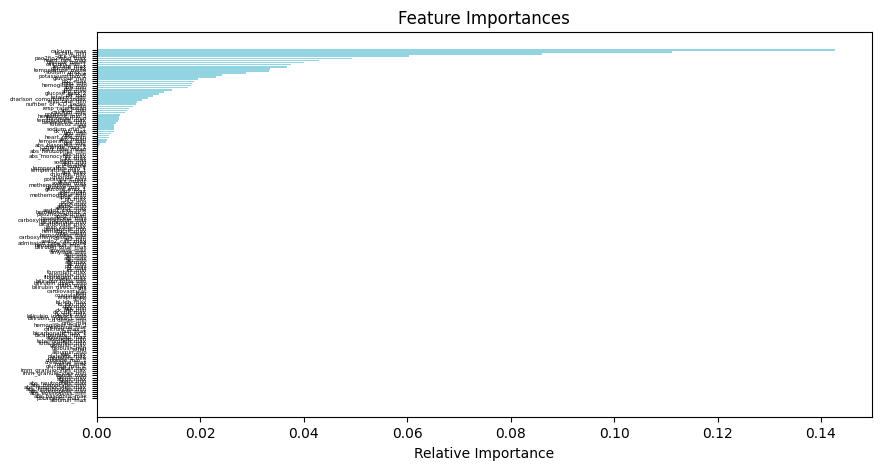

In [ ]:
## calculate feature importances
feature_name = list(X_train.columns.values)
importances = xg_reg.feature_importances_

## sort importances
indices = np.argsort(importances)

## plot importance bar chart
plt.figure(figsize = (10,5), dpi = 100)

plt.rc('ytick', labelsize=4)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices],
         color = '#66C2D7', align = 'center', alpha = 0.7)
plt.yticks(range(len(indices)), np.array(feature_name)[indices])
plt.xlabel('Relative Importance')
plt.style.use('default')

In [ ]:
import numpy as np

# 假设已有的importances数组和feature_name列表
# importances = [0.0, 0.1, 0.0, 0.05, 0.2]  # 示例数据
# feature_name = ['feature1', 'feature2', 'feature3', 'feature4', 'feature5']  # 示例数据

# 筛选出非零重要性的特征名称
non_zero_indices = np.where(importances != 0)[0]  # 找出所有非零重要性的索引
non_zero_features = [feature_name[i] for i in non_zero_indices]  # 使用索引获取对应的特征名称

# 输出非零重要性的特征名称
print(non_zero_features)


['age', 'number_of_ICD_codes', 'charlson_comorbidity_index', 'heart_rate_min', 'heart_rate_max', 'heart_rate_mean', 'sbp_min', 'sbp_max', 'sbp_mean', 'dbp_min', 'mbp_min', 'mbp_max', 'resp_rate_min', 'resp_rate_mean', 'temperature_min', 'temperature_max', 'temperature_mean', 'spo2_min', 'glucose_min', 'glucose_max', 'glucose_mean', 'lactate_min', 'lactate_max', 'ph_min', 'po2_min', 'po2_max', 'pao2fio2ratio_max', 'baseexcess_min', 'totalco2_min', 'totalco2_max', 'hemoglobin_min', 'calcium_min', 'calcium_max', 'potassium_min', 'gcs_min', 'gcs_verbal', 'hematocrit_min_1', 'wbc_min', 'bun_min', 'calcium_min_1', 'chloride_max_1', 'glucose_max_2', 'sodium_min_1', 'sodium_max_1', 'potassium_min_1', 'abs_basophils_min', 'abs_monocytes_max', 'abs_neutrophils_min', 'fibrinogen_min', 'inr_max', 'pt_min', 'ptt_min', 'ck_mb_max']


In [ ]:
from pycebox.ice import ice, ice_plot

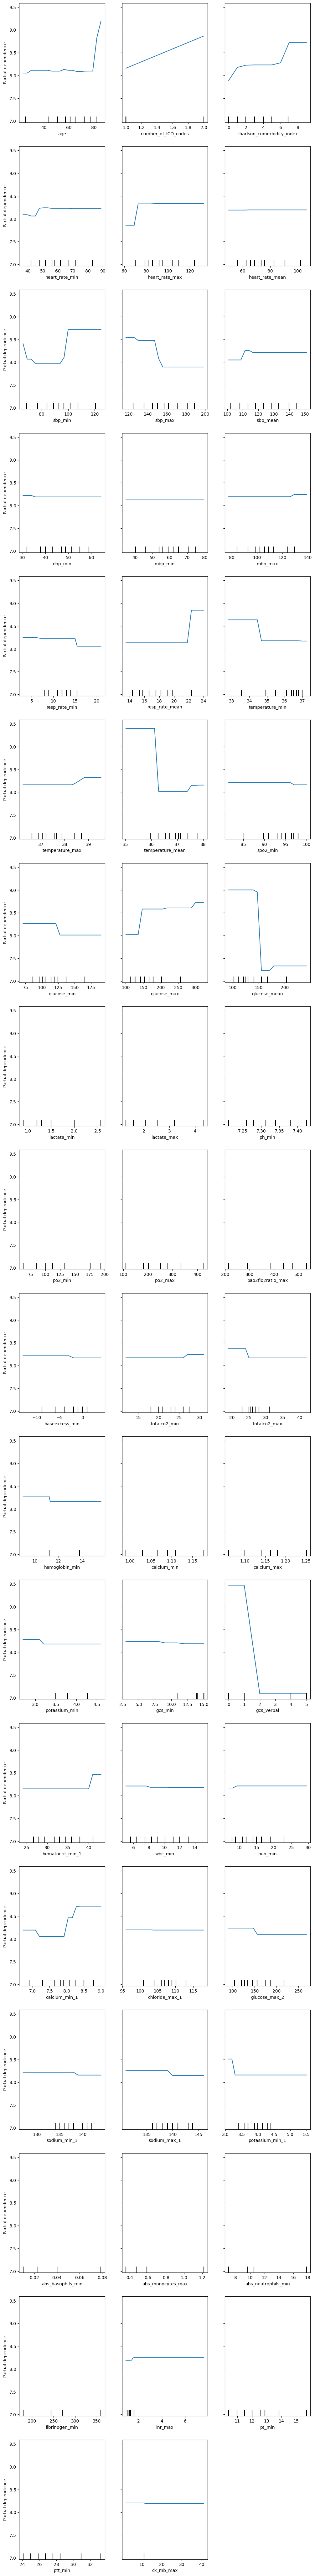

In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# List of features for which we wish to plot the PDPs
# You should replace these indices with the actual feature names or indices of interest in your dataset
features = list(non_zero_features)  # Plotting PDP for all features for demonstration

# Plot Partial Dependence
fig, ax = plt.subplots(figsize=(12, (len(features) * 2)))  # Adjust the size as needed
display = PartialDependenceDisplay.from_estimator(xg_reg, X_train, features, ax=ax, grid_resolution=20, kind='average')

plt.show()